![title](images/image3.png)

# CONTENTS

SESSION 1 --- 45 MINUTES 

1. What is Feature Engineering

2. Why Feature Engineering

3. Introduction to Automated Feature Engineering


SESSION 2 --- 45 MINUTES 
4. Introduction to Principal Component Analysis (PCA).

5. Introduction to Linear Discriminant Analysis (LDA).

SESSION 3 --- 30 MINUTES

6. Kernel PCA
7. Chat on Phd Opportunities.


Note: 15 minutes break at the end of each session.

# What is Feature Engineering?

Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning, and is both difficult and expensive ~ Wikipedia

FEATURE CONSTRUCTION:


FEATURE EXTRACTION:



FEATURE SELECTION:

Sequential feature selection algorithms are a family of greedy search algorithms that
are used to reduce an initial d-dimensional feature space to a k-dimensional feature
subspace where k < d. A classic sequential feature selection algorithm is Sequential
Backward Selection (SBS), which aims to reduce the dimensionality of the initial
feature subspace with a minimum decay in performance of the classifier to improve
upon computational efficiency. Other techniqies involve using Random Forest, L1 regularization to zero out irrelevant features

# Why Feature Engineering?

Feature Engineeing is an Essential Part of Machine learning pipeline. It is time consuming, but often time makes the difference in 
1. The predictive power of a model.
2. The computational efficiency.


![title](images/image1.png)


“Coming up with features is difficult, time-consuming, requires expert knowledge. ‘Applied machine learning’ is basically feature engineering.”
— Prof. Andrew Ng.


“Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data.”
— Dr. Jason Brownlee


Prof. Pedro Domingos from the University of Washington, in his paper titled, “A Few Useful Things to Know about Machine Learning” tells us the following.
“At the end of the day, some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used.”
— Prof. Pedro Domingos


“The algorithms we used are very standard for Kagglers. …We spent most of our efforts in feature engineering. … We were also very careful to discard features likely to expose us to the risk of over-fitting our model.”
— Xavier Conort

# Introduction: Automated Feature Engineering (Featuretools)



![title](images/image2.png)


Reference: This section of the notebook is from WillKoehrsen: https://github.com/WillKoehrsen

In this notebook, we will look at an exciting development in data science: automated feature engineering. A machine learning model can only learn from the data we give it, and making sure that data is relevant to the task is one of the most crucial steps in the machine learning pipeline (this is made clear in the excellent paper ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)). 


In this notebook, we will walk through an implementation of using [Featuretools](https://www.featuretools.com/), an open-source Python library for automatically creating features with relational data (where the data is in structured tables). Although there are now many efforts working to enable automated model selection and hyperparameter tuning, there has been a lack of automating work on the feature engineering aspect of the pipeline. This library seeks to close that gap and the general methodology has been proven effective in both [machine learning competitions with the data science machine](https://github.com/HDI-Project/Data-Science-Machine) and [business use cases](https://www.featurelabs.com/blog/predicting-credit-card-fraud/). 


## Dataset

To show the basic idea of featuretools we will use an example dataset consisting of three tables:

* `clients`: information about clients at a credit union
* `loans`: previous loans taken out by the clients
* `payments`: payments made/missed on the previous loans

The general problem of feature engineering is taking disparate data, often distributed across multiple tables, and combining it into a single table that can be used for training a machine learning model. Featuretools has the ability to do this for us, creating many new candidate features with minimal effort. These features are combined into a single table that can then be passed on to our model. 

First, let's load in the data and look at the problem we are working with.

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# featuretools for automated feature engineering
import featuretools as ft
# If featuretools is not installed do: python -m pip install featuretools or !pip install -U featuretools

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Read in the data
clients = pd.read_csv('/home/samuel/Documents/automated-feature-engineering/walk_through/data/clients.csv', parse_dates = ['joined'])
loans = pd.read_csv('/home/samuel/Documents/automated-feature-engineering/walk_through/data/loans.csv', parse_dates = ['loan_start', 'loan_end'])
payments = pd.read_csv('/home/samuel/Documents/automated-feature-engineering/walk_through/data/payments.csv', parse_dates = ['payment_date'])

In [ ]:
clients.shape, loans.shape , payments.shape

In [ ]:
clients

In [ ]:
loans.loc[loans['client_id'].isin([46109])]

In [ ]:
payments.sample(10)

### Manual Feature Engineering Examples

Let's show a few examples of features we might make by hand. We will keep this relatively simple to avoid doing too much work! First we will focus on a single dataframe before combining them together. In the `clients` dataframe, we can take the month of the `joined` column and the natural log of the `income` column. Later, we see these are known in featuretools as transformation feature primitives because they act on column in a single table. 

In [ ]:
# Create a month column
clients['join_month'] = clients['joined'].dt.month

# Create a log of income column
clients['log_income'] = np.log(clients['income'])

clients.head()

To incorporate information about the other tables, we use the `df.groupby` method, followed by a suitable aggregation function, followed by `df.merge`.  For example, let's calculate the average, minimum, and maximum amount of previous loans for each client. In the terms of featuretools, this would be considered an aggregation feature primitive because we using multiple tables in a one-to-many relationship to calculate aggregation figures (don't worry, this will be explained shortly!).

In [ ]:
# Groupby client id and calculate mean, max, min previous loan size
stats = loans.groupby('client_id')['loan_amount'].agg(['mean', 'max', 'min'])
stats.columns = ['mean_loan_amount', 'max_loan_amount', 'min_loan_amount']
stats.head()

In [ ]:
# Merge with the clients dataframe
clients.merge(stats, left_on = 'client_id', right_index=True, how = 'left').head(10)

We could go further and include information about `clients` in the `payment` dataframe. To do so, we would have to group `payments` by the `loan_id`, merge it with the `loans`, group the resulting dataframe by the `client_id`, and then merge it into the `clients` dataframe. This would allow us to include information about previous payments for each client. 

Clearly, this process of manual feature engineering can grow quite tedious with many columns and multiple tables and I certainly don't want to have to do this process by hand! Luckily, featuretools can automatically perform this entire process and will create more features than we would have ever thought of. Although I love `pandas`, there is only so much manual data manipulation I'm willing to stand! 

# Featuretools

Now that we know what we are trying to avoid (tedious manual feature engineering), let's figure out how to automate this process. Featuretools operates on an idea known as [Deep Feature Synthesis](https://docs.featuretools.com/api_reference.html#deep-feature-synthesis). You can read the [original paper here](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf), and although it's quite readable, it's not necessary to understand the details to do automated feature engineering. The concept of Deep Feature Synthesis is to use basic building blocks known as feature primitives (like the transformations and aggregations done above) that can be stacked on top of each other to form new features. The depth of a "deep feature" is equal to the number of stacked primitives. 

I threw out some terms there, but don't worry because we'll cover them as we go. Featuretools builds on simple ideas to create a powerful method, and we will build up our understanding in much the same way. 

The first part of Featuretools to understand [is an `entity`](https://docs.featuretools.com/loading_data/using_entitysets.html#adding-entities). This is simply a table, or in `pandas`, a `DataFrame`. We corral multiple entities into a [single object called an `EntitySet`](https://docs.featuretools.com/loading_data/using_entitysets.html). This is just a large data structure composed of many individual entities and the relationships between them.  

## EntitySet

Creating a new `EntitySet` is pretty simple: 

In [ ]:
es = ft.EntitySet(id = 'clients')

## Entities 

An entity is simply a table, which is represented in Pandas as a `dataframe`. Each entity must have a uniquely identifying column, known as an index. For the clients dataframe, this is the `client_id` because each id only appears once in the `clients` data. In the `loans` dataframe, `client_id` is not an index because each id might appear more than once. The index for this dataframe is instead `loan_id`. 

When we create an `entity` in featuretools, we have to identify which column of the dataframe is the index. If the data does not have a unique index we can tell featuretools to make an index for the entity by passing in `make_index = True` and specifying a name for the index. If the data also has a uniquely identifying time index, we can pass that in as the `time_index` parameter. 

Featuretools will automatically infer the variable types (numeric, categorical, datetime) of the columns in our data, but we can also pass in specific datatypes to override this behavior. As an example, even though the `repaid` column in the `loans` dataframe is represented as an integer, we can tell featuretools that this is a categorical feature since it can only take on two discrete values. This is done using an integer with the variables as keys and the feature types as values.

In the code below we create the three entities and add them to the `EntitySet`.  The syntax is relatively straightforward with a few notes: for the `payments` dataframe we need to make an index, for the `loans` dataframe, we specify that `repaid` is a categorical variable, and for the `payments` dataframe, we specify that `missed` is a categorical feature. 

In [ ]:
# Create an entity from the client dataframe
# This dataframe already has an index and a time index
es = es.entity_from_dataframe(entity_id = 'clients', dataframe = clients, 
                              index = 'client_id', time_index = 'joined')

In [ ]:
# Create an entity from the loans dataframe
# This dataframe already has an index and a time index
es = es.entity_from_dataframe(entity_id = 'loans', dataframe = loans, 
                              variable_types = {'repaid': ft.variable_types.Categorical},
                              index = 'loan_id', 
                              time_index = 'loan_start')

In [ ]:
# Create an entity from the payments dataframe
# This does not yet have a unique index
es = es.entity_from_dataframe(entity_id = 'payments', 
                              dataframe = payments,
                              variable_types = {'missed': ft.variable_types.Categorical},
                              make_index = True,
                              index = 'payment_id',
                              time_index = 'payment_date')

In [ ]:
es

All three entities have been successfully added to the `EntitySet`. We can access any of the entities using Python dictionary syntax.

In [ ]:
es['loans']

Featuretools correctly inferred each of the datatypes when we made this entity. We can also see that we overrode the type for the `repaid` feature, changing if from numeric to categorical. 

In [ ]:
es['payments']

## Relationships

After defining the entities (tables) in an `EntitySet`, we now need to tell featuretools [how they are related with a relationship](https://docs.featuretools.com/loading_data/using_entitysets.html#adding-a-relationship). The most intuitive way to think of relationships is with the parent to child analogy: a parent-to-child relationship is one-to-many because for each parent, there can be multiple children. The `client` dataframe is therefore the parent of the `loans` dataframe because while there is only one row for each client in the `client` dataframe, each client may have several previous loans covering multiple rows in the `loans` dataframe. Likewise, the `loans` dataframe is the parent of the `payments` dataframe because each loan will have multiple payments. 

These relationships are what allow us to group together datapoints using aggregation primitives and then create new features. As an example, we can group all of the previous loans associated with one client and find the average loan amount. We will discuss the features themselves more in a little bit, but for now let's define the relationships. 

To define relationships, we need to specify the parent variable and the child variable. This is the variable that links two entities together. In our example, the `client` and `loans` dataframes are linked together by the `client_id` column. Again, this is a parent to child relationship because for each `client_id` in the parent `client` dataframe, there may be multiple entries of the same `client_id` in the child `loans` dataframe. 

We codify relationships in the language of featuretools by specifying the parent variable and then the child variable. After creating a relationship, we add it to the `EntitySet`. 

In [ ]:
# Relationship between clients and previous loans
r_client_previous = ft.Relationship(es['clients']['client_id'],
                                    es['loans']['client_id'])

# Add the relationship to the entity set
es = es.add_relationship(r_client_previous)

The relationship has now been stored in the entity set. The second relationship is between the `loans` and `payments`. These two entities are related by the `loan_id` variable.

In [ ]:
# Relationship between previous loans and previous payments
r_payments = ft.Relationship(es['loans']['loan_id'],
                                      es['payments']['loan_id'])

# Add the relationship to the entity set
es = es.add_relationship(r_payments)

es

We now have our entities in an entityset along with the relationships between them. We can now start to making new features from all of the tables using stacks of feature primitives to form deep features. First, let's cover feature primitives.


## Feature Primitives

A [feature primitive](https://docs.featuretools.com/automated_feature_engineering/primitives.html) a at a very high-level is an operation applied to data to create a feature. These represent very simple calculations that can be stacked on top of each other to create complex features. Feature primitives fall into two categories:

* __Aggregation__: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
* __Transformation__: an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

Let's take a look at feature primitives in featuretools. We can view the list of primitives:

In [ ]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

In [ ]:
primitives[primitives['type'] == 'transform'].head(10)

If featuretools does not have enough primitives for us, we can [also make our own.](https://docs.featuretools.com/automated_feature_engineering/primitives.html#defining-custom-primitives) 

To get an idea of what a feature primitive actually does, let's try out a few on our data. Using primitives is surprisingly easy using the `ft.dfs` function (which stands for deep feature synthesis). In this function, we specify the entityset to use; the `target_entity`, which is the dataframe we want to make the features for (where the features end up); the `agg_primitives` which are the aggregation feature primitives; and the `trans_primitives` which are the transformation primitives to apply. 

In the following example, we are using the `EntitySet` we already created, the target entity is the `clients` dataframe because we want to make new features about each client, and then we specify a few aggregation and transformation primitives. 

In [ ]:
# Create new features using specified primitives
features, feature_names = ft.dfs(entityset = es, target_entity = 'clients', 
                                 agg_primitives = ['mean', 'max', 'percent_true', 'last'],
                                 trans_primitives = ['year', 'month', 'subtract_numeric_scalar', 'divide_numeric_scalar'])

In [ ]:
pd.DataFrame(features['MONTH(joined)'].head())

In [ ]:
pd.DataFrame(features['MEAN(payments.payment_amount)'].head())

In [ ]:
features.head()

Already we can see how useful featuretools is: it performed the same operations we did manually but also many more in addition. Examining the names of the features in the dataframe brings us to the final piece of the puzzle: deep features.

## Deep Feature Synthesis

While feature primitives are useful by themselves, the main benefit of using featuretools arises when we stack primitives to get deep features. The depth of a feature is simply the number of primitives required to make a feature. So, a feature that relies on a single aggregation would be a deep feature with a depth of 1, a feature that stacks two primitives would have a depth of 2 and so on. The idea itself is lot simpler than the name "deep feature synthesis" implies. (I think the authors were trying to ride the way of deep neural network hype when they named the method!) To read more about deep feature synthesis, check out [the documentation](https://docs.featuretools.com/automated_feature_engineering/afe.html) or the [original paper by Max Kanter et al](http://www.jmaxkanter.com/static/papers/DSAA_DSM_2015.pdf). 

Already in the dataframe we made by specifying the primitives manually we can see the idea of feature depth. For instance, the MEAN(loans.loan_amount) feature has a depth of 1 because it is made by applying a single aggregation primitive. This feature represents the average size of a client's previous loans.

In [ ]:
# Show a feature with a depth of 1
pd.DataFrame(features['MEAN(loans.loan_amount)'].head(10))

In [ ]:
features.columns

As well scroll through the features, we see a number of features with a depth of 2. For example, the LAST(loans.(MEAN(payments.payment_amount))) has depth = 2 because it is made by stacking two feature primitives, first an aggregation and then a transformation. This feature represents the average payment amount for the last (most recent) loan for each client.

In [ ]:
# Show a feature with a depth of 2
pd.DataFrame(features['LAST(loans.MEAN(payments.payment_amount))'].head(10))

We can create features of arbitrary depth by stacking more primitives. However, when I have used featuretools I've never gone beyond a depth of 2! After this point, the features become very convoluted to understand. I'd encourage anyone interested to experiment with increasing the depth (maybe for a real problem) and see if there is value to "going deeper".

## Automated Deep Feature Synthesis

In addition to manually specifying aggregation and transformation feature primitives, we can let featuretools automatically generate many new features. We do this by making the same `ft.dfs` function call, but without passing in any primitives. We just set the `max_depth` parameter and featuretools will automatically try many all combinations of feature primitives to the ordered depth. 

When running on large datasets, this process can take quite a while, but for our example data, it will be relatively quick. For this call, we only need to specify the `entityset`, the `target_entity` (which will again be `clients`), and the `max_depth`. 

In [ ]:
# Perform deep feature synthesis without specifying primitives
features, feature_names = ft.dfs(entityset=es, target_entity='clients', 
                                 max_depth = 2)

In [ ]:
features.shape

In [ ]:
features.iloc[:, 4:].head()

Deep feature synthesis has created 90 new features out of the existing data! While we could have created all of these manually, I am glad to not have to write all that code by hand. The primary benefit of featuretools is that it creates features without any subjective human biases. Even a human with considerable domain knowledge will be limited by their imagination when making new features (not to mention time). Automated feature engineering is not limited by these factors (instead it's limited by computation time) and provides a good starting point for feature creation. This process likely will not remove the human contribution to feature engineering completely because a human can still use domain knowledge and machine learning expertise to select the most important features or build new features from those suggested by automated deep feature synthesis.

# Next Steps

While automatic feature engineering solves one problem, it provides us with another problem: too many features! Although it's difficult to say which features will be important to a given machine learning task ahead of time, it's likely that not all of the features made by featuretools add value. In fact, having too many features is a significant issue in machine learning because it makes training a model much harder. The [irrelevant features can drown out the important features](https://pdfs.semanticscholar.org/a83b/ddb34618cc68f1014ca12eef7f537825d104.pdf), leaving a model unable to learn how to map the features to the target.

This problem is known as the ["curse of dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Machine_learning) and is addressed through the process of [feature reduction and selection](http://scikit-learn.org/stable/modules/feature_selection.html), which means [removing low-value features](https://machinelearningmastery.com/feature-selection-machine-learning-python/) from the data. Defining which features are useful is an important problem where a data scientist can still add considerable value to the feature engineering task. Feature reduction will have to be another topic for another day!

# Conclusions

In this notebook, we saw how to apply automated feature engineering to an example dataset. This is a powerful method which allows us to overcome the human limits of time and imagination to create many new features from multiple tables of data. Featuretools is built on the idea of deep feature synthesis, which means stacking multiple simple feature primitives - __aggregations and transformations__ - to create new features. Feature engineering allows us to combine information across many tables into a single dataframe that we can then use for machine learning model training. Finally, the next step after creating all of these features is figuring out which ones are important. 

Featuretools is currently the only Python option for this process, but with the recent emphasis on automating aspects of the machine learning pipeline, other competitiors will probably enter the sphere. While the exact tools will change, the idea of automatically creating new features out of existing data will grow in importance. Staying up-to-date on methods such as automated feature engineering is crucial in the rapidly changing field of data science. Now go out there and find a problem on which to apply featuretools! 

For more information, check out the [documentation for featuretools](https://docs.featuretools.com/index.html). Also, read about how featuretools is [used in the real world by Feature Labs](https://www.featurelabs.com/), the company behind the open-source library.

![title](images/image6.jpeg)

# Introduction to Princcipal Component Analysis

![title](images/image4.png)

This isection of the notebook is from: Python Machine Learning by Sebastian Raschka (https://sites.google.com/site/24nop18o/6wS3DfTv7062)

The PCA is an unsupervised linear transformation technique that is widely used across different fields, most prominently for dimensionality reduction. Other popular applications of PCA include exploratory data analyses and de-noising of signals in stock market trading, and the analysis genome data and gene expression levels in the 
field of bioinformatics. In the first session, in our attempt to create features, we resulted in creating enough features using the featuretools, which might not be relevant. However, we will use the PCA in selecting and projecting only dimensions of the dataset that best explain the variance in the data.




Summary of the PCA Algorithm
1. Standardize the d -dimensional dataset.
2. Construct the covariance matrix.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Select k eigenvectors that correspond to the k largest eigenvalues,
where k is the dimensionality of the new feature subspace ( k ≤ d ).
5. Construct a projection matrix W from the "top" k eigenvectors.
6. Transform the d -dimensional input dataset X using the projection
matrix W to obtain the new k -dimensional feature subspace.

In [ ]:
features.head()
features_del_mode = features.drop('MODE(loans.loan_type)', axis=1)
features_del_mode['credit_score_class'] = np.where(features_del_mode['credit_score']>=700, 1, 0)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#split into train and test set
X_train = features_del_mode.loc[: ,  (features_del_mode.columns != 'credit_score_class') & (features_del_mode.columns != 'credit_score')].values
y_train = features_del_mode['credit_score_class'].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#drop a column using: features_del_mode = features.drop('MODE(loans.loan_type)', axis=1)

#standardize
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
#y_train_std = sc.fit_transform(y_train)
#X_test_std = sc.fit_transform(X_test)

In [ ]:
X.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_train_pca_sci = pca.fit_transform(X_train_std)

In [ ]:
pca.explained_variance_

In [ ]:
data_column = features_del_mode.loc[: , (features_del_mode.columns != 'credit_score_class') & (features_del_mode.columns != 'credit_score')]
print(pd.DataFrame(pca.components_,columns=data_column.columns,index = ['PC-1','PC-2','PC-3']))

# Introduction to Linear Discriminant Analysis

The general concept behind LDA is very similar to PCA, whereas PCA attempts to
find the orthogonal component axes of maximum variance in a dataset; the goal in
LDA is to find the feature subspace that optimizes class separability. Both LDA and
PCA are linear transformation techniques that can be used to reduce the number of
dimensions in a dataset; the former is an unsupervised algorithm, whereas the latter is
supervised. Thus, we might intuitively think that LDA is a superior feature extraction
technique for classification tasks compared to PCA. However, A.M. Martinez reported
that preprocessing via PCA tends to result in better classification results in an image
recognition task in certain cases, for instance, if each class consists of only a small
number of samples (A. M. Martinez and A. C. Kak. PCA Versus LDA. Pattern
Analysis and Machine Intelligence, IEEE Transactions on, 23(2):228–233, 2001).

One assumption in LDA is that the data is normally distributed. Also, we assume
that the classes have identical covariance matrices and that the features are
statistically independent of each other.


Summary of the key steps in LDA approach:
1. Standardize the d -dimensional dataset ( d is the number of features).
2. For each class, compute the d -dimensional mean vector.
3. Construct the between-class scatter matrix $S_{b}$ and the within-class scatter
matrix $S_{w}$.
4. Compute the eigenvectors and corresponding eigenvalues of the
matrix $S_{w}^{−1}S_{b}$.
5. Choose the k eigenvectors that correspond to the k largest eigenvalues to
construct a d × k -dimensional transformation matrix W ; the eigenvectors are
the columns of this matrix.
6. Project the samples onto the new feature subspace using the transformation
matrix W .

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda_sci = lda.fit_transform(X_train_std, y_train)

![title](images/image6.jpeg)

# Introduction to Kernel PCA

![title](images/image5.png)

# Using Kernel PCA For Nonlinear Mappings

Many machine learning algorithms make assumptions about the linear separability
of the input data. You must have learned that the perceptron even requires perfectly linearly
separable training data to converge. Other algorithms 
assume that the lack of perfect linear separability is due to noise: Adaline, logistic
regression, and the (standard) support vector machine (SVM) to just name a few.
However, if we are dealing with nonlinear problems, which we may encounter
rather frequently in real-world applications, linear transformation techniques for
dimensionality reduction, such as PCA and LDA, may not be the best choice. In this
section, we will take a look at a kernelized version of PCA, or kernel PCA, which
relates to the concepts of kernel SVM. Using kernel PCA, we will learn how to
transform data that is not linearly separable onto a new, lower-dimensional subspace
that is suitable for linear classifiers.

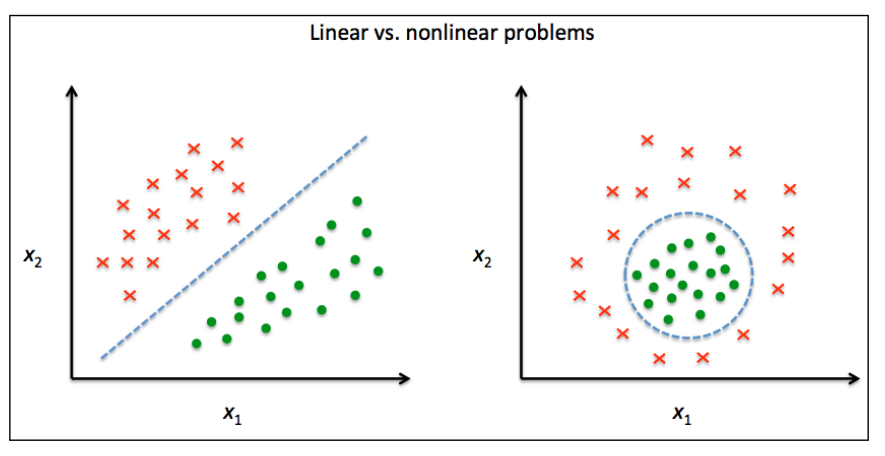

In [6]:
from IPython.display import Image
Image(filename='./images/kernelpca.png', width=600, height=600)

To do this, via kernel PCA we perform a nonlinear mapping that
transforms the data onto a higher-dimensional space and use standard PCA in this
higher-dimensional space to project the data back onto a lower-dimensional space
where the samples can be separated by a linear classifier (under the condition that the
samples can be separated by density in the input space). However, one downside of
this approach is that it is computationally very expensive, and this is where we use
the kernel trick. Using the kernel trick, we can compute the similarity between two
high-dimension feature vectors in the original feature space.

The most commonly used kernels are: polynomial kernel, hyperbolic tangent kernel, radial basis function/Gaussian kernel etc.

In summary, we can define the following three steps to implement an RBF kernel PCA:

1. We compute the kernel (similarity) matrix k , where we need to calculate
the following: $k(x^i, x^j) =  exp(-\gamma \mid x^i - x^j \mid^2).$This is used to construct the the symmetric
kernel matrix $\textbf{K}$ of the pair-wise similarities

2. We center the kernel matrix $\textbf{K}$ using the following equation: $\textbf{K}^{\prime} = \textbf{K} − \textbf{I}_n\textbf{K} − \textbf{K}\textbf{I}_n + 
\textbf{I}_n \textbf{K}\textbf{I}_n$ where $\textbf{I}_n$ is an $n \times n$ matrice with values $\frac{1}{n}.$

3. We collect the top k eigenvectors of the centered kernel matrix based on
their corresponding eigenvalues, which are ranked by decreasing magnitude.
$\textit{In contrast to standard PCA, the eigenvectors are not the principal
component axes but the samples projected onto those axes.}$

In [8]:
#Kernel PCA in Scikit learn
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

scikit_kpca = KernelPCA(n_components=2,kernel='rbf', gamma=15)
X_skernpca = scikit_kpca.fit_transform(X)

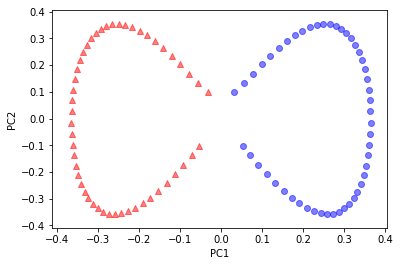

In [11]:
import matplotlib.pyplot as plt
plt.scatter(X_skernpca[y==0, 0], X_skernpca[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X_skernpca[y==1, 0], X_skernpca[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

![title](images/image8.png)